In [68]:
import cv2
import numpy as np
import json
import time
import math
import os

from glob import glob
from matplotlib import pyplot as plt
from collections import Counter
from sklearn.metrics.pairwise import euclidean_distances

class KMeans:
    
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        self.compactness = None
        self.label = None
        self.center = None
        
    def fit(self, data):
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        self.compactness, self.label, self.center = cv2.kmeans(
            data, self.n_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    def predict(self, vectors):
        """
        Vector may need to be reshaped with (1, -1)
        Takes in a list of vectors
        """
        cluster_labels = []
        for vect in vectors:
            dist = []
            for idx, c in enumerate(self.center):
                dist.append(euclidean_distances(vect.reshape(1, -1), c.reshape(1, -1)))
            cluster_labels.append(dist.index(min(dist)))
        
        return cluster_labels


class DescriptorGenerator:
    """
    Class to help with image processing and retrieval of descriptors
    """
    des_obj = None
    
    def __init__(self, method='sift', nfeatures=2000):
        if method == "sift":
            self.des_obj = cv2.xfeatures2d.SIFT_create(nfeatures=nfeatures)
        elif method == "surf":
            self.des_obj = cv2.xfeatures2d.SURF_create(nfeatures=nfeatures)

    def gray(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return gray

    def features(self, image):
        keypoints, descriptors = self.des_obj.detectAndCompute(image, None)
        return [keypoints, descriptors]

In [69]:
class BOVW:
    def __init__(self, data_path, method='sift', n_clusters=10, nfeatures=2000):
        self.t = time.time()
        self.n_clusters = n_clusters
        self.path = data_path

        self.opencv = DescriptorGenerator(method=method, nfeatures=nfeatures)
        self.kmeans = KMeans(n_clusters=n_clusters)
        self.descriptor_vstack = None

        self.images = None
        self.image_count = 0
        self.descriptor_list = []
        self.image_vocab = {}
        self.tfidf_corpus = None
        
    def cluster(self):
        """	
        cluster using KMeans algorithm, 
        """
        self.kmeans.fit(self.descriptor_vstack)
      
    def format_data(self, list_items):
        """	
        restructures list into vstack array of shape
        M samples x N features for sklearn
        """
        v_stack = np.array(list_items[0])
        for r in list_items[1:]:
            v_stack = np.vstack((v_stack, r))
        self.descriptor_vstack = v_stack.copy()
        return v_stack

    def plot_hist(self):
        print("Plotting histogram")
        counts = Counter(self.kmeans.label.flatten())
        
        x = list(counts.keys())
        y = list(counts.values())

        plt.bar(x, y)
        plt.xlabel("Visual Word Index")
        plt.ylabel("Frequency")
        plt.title("Complete Vocabulary Generated")
        plt.xticks(np.array(x) + 0.4, x)
        plt.savefig("visual_word_histogram.jpg")
        plt.show()

    def load_images(self):
        imlist = {}
        count = 0
        print("Loading images from: ", self.path)
        for f in glob(self.path + "*"):
            imfile = f.split("/")[-1]
            print("Loading image file {} ==========".format(imfile))
            im = cv2.imread(f, 0)
            imlist[imfile] = im
            count +=1

        self.images = imlist
        self.image_count = count

    def train_vocabulary(self):
        """
        This method contains the entire module 
        required for training the bag of visual words model
        Use of helper functions will be extensive.
        """

        # read file. prepare file lists.
        if not self.images:
            self.load_images()

        for im, imlist in self.images.items():
            print("Computing Features for image: ", im)
            lkp, des = self.opencv.features(imlist)
            print("descriptor length", len(des))
            self.descriptor_list.append(des)

        print("Formatting data")
        self.format_data(self.descriptor_list)
        print("Performing Clustering")
        self.cluster()
        self.plot_hist()

    def generate_vocabulary(self):
        """
        Generates vocabulary for each image
        """
        self.image_vocab = {}
        for im, imlist in self.images.items():
            vocab = self.generate_vocab(imlist)
            self.image_vocab[im] = list(vocab)
        
        # save a copy first
        with open("vocabs_{}.txt".format(self.t), "w") as f:
            try:
                json.dump([self.image_vocab], f)
            except:
                pass
        return self.image_vocab

    def generate_redis(self, data_dict, redis_path):
        print("Generating file for redis")
        with open(redis_path, "w") as redis_f:
            for key, value in data_dict.items():
                redis_f.write("SET {} {}".format(key, value))
                redis_f.write("\n")
        
    def generate_vocab(self, img):
        """ 
        This method generates the vocabulary for an image
        It returns a vector of length n_clusters with its frequency count
        """
        kp, des = self.opencv.features(img)

        vocab = [[0 for i in range(self.n_clusters)]]
        
        test_ret = self.kmeans.predict(des)

        for each in test_ret:
            vocab[0][each] += 1

        return vocab

Loading images from:  /Users/sherly/Documents/jpg/100
Loading image file 100000.jpg ==========
Loading image file 100001.jpg ==========
Loading image file 100002.jpg ==========
Loading image file 100100.jpg ==========
Loading image file 100101.jpg ==========
Loading image file 100200.jpg ==========
Loading image file 100201.jpg ==========
Loading image file 100300.jpg ==========
Loading image file 100301.jpg ==========
Loading image file 100302.jpg ==========
Loading image file 100400.jpg ==========
Loading image file 100401.jpg ==========
Loading image file 100500.jpg ==========
Loading image file 100501.jpg ==========
Loading image file 100502.jpg ==========
Loading image file 100503.jpg ==========
Loading image file 100600.jpg ==========
Loading image file 100601.jpg ==========
Loading image file 100700.jpg ==========
Loading image file 100701.jpg ==========
Loading image file 100800.jpg ==========
Loading image file 100801.jpg ==========
Loading image file 100900.jpg ==========
Loa

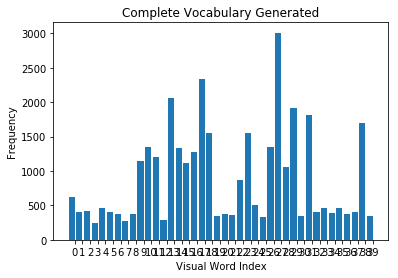

In [70]:
current_dir = os.getcwd()
n_clusters = 40
image_dir = os.path.join(current_dir, "images/100")
bovw = BOVW(image_dir, n_clusters=n_clusters, nfeatures=1500)

bovw.train_vocabulary()

In [ ]:
bovw.generate_vocabulary()

In [72]:
from sklearn.metrics.pairwise import cosine_similarity

class TFIDF:
    
    def __init__(self, corpus, n_clusters):
        self.corpus = corpus
        self.idf = None
        self.n_clusters = n_clusters
        
    def compute_TF(self, bow):
        """
        Term Frequency = Number of occurences of word j in document d /
                         Number of words in document d
        The parameter bow refers to the bag of words which represents
        the frequencey of each word in the bag
        """
        n_words = len(bow[0])
        tf_bow = np.array(bow[0]) / n_words
        return tf_bow

    def generate_IDF_dict(self):
        """
        IDF = log(total no. of docs / number of docs which has word j)
        """
        n_docs = len(self.corpus)
        idf_dict = dict.fromkeys(range(self.n_clusters), 0)
        
        for img, corp in self.corpus.items():
            for idx, count in enumerate(corp[0]):
                if int(count) > 0:
                    idf_dict[idx] += 1
        for idx, count in idf_dict.items():
            idf_dict[idx] = math.log10(n_docs / float(count))
            
        self.idf = idf_dict
        return idf_dict
    
    def compute_TFIDF(self, bow):
        tf_bow = self.compute_TF(bow)
        tfidf = np.zeros(self.n_clusters)
        for idx, tf in enumerate(tf_bow):
            tfidf[idx] = tf * self.idf[idx]
        return tfidf
    
    @staticmethod
    def cosine_similarity(v1, v2):
        return cosine_similarity(v1.reshape(1, -1), v2.reshape(1, -1))

In [73]:
tfidf = TFIDF(bovw.image_vocab, n_clusters)

In [62]:
tfidf.generate_IDF_dict()

{0: 0.0,
 1: 0.017728766960431616,
 2: 0.05551732784983141,
 3: 0.0,
 4: 0.0,
 5: 0.03621217265444471,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.03621217265444471,
 10: 0.03621217265444471,
 11: 0.03621217265444471,
 12: 0.0,
 13: 0.03621217265444471,
 14: 0.0,
 15: 0.05551732784983141,
 16: 0.03621217265444471,
 17: 0.03621217265444471,
 18: 0.03621217265444471,
 19: 0.03621217265444471}

In [63]:
tfidf.compute_TFIDF(bovw.image_vocab['100000.jpg'])

array([0.        , 0.01063726, 0.03053453, 0.        , 0.        ,
       0.09958347, 0.        , 0.        , 0.        , 0.21727304,
       0.08871982, 0.06156069, 0.        , 0.86909214, 0.        ,
       0.09715532, 0.18287147, 0.08509861, 0.11950017, 0.23356851])

In [65]:
from collections import defaultdict

def generate_inverted_index(image_vocab):
    inv_indx = defaultdict(list)
    
    for imgidx, vocab in image_vocab.items():
        for idx, count in enumerate(vocab[0]):
            if int(count) > 0:
                inv_indx[idx].append(imgidx)
    return inv_indx

In [ ]:
generate_inverted_index(bovw.image_vocab)

In [18]:
import redis
from collections import defaultdict

class Redis:
    def __init__(self):
        self.redis = redis.Redis(host='localhost', port=6379, db=0)

    def mset(self, dict_vals):
        """
        dict_vals format: k, list(v)
        """
        redis_f = defaultdict()
        for k, v in dict_vals.items():
            redis_f[k] = json.dumps(v)

        self.redis.mset(redis_f)
        
    def get(self, key):
        return json.loads(self.redis.get(key))

In [19]:
r = Redis()

In [21]:
r.mset(bovw.image_vocab)

In [23]:
type(r.get("100700.jpg"))

list

## Retrieval

In [79]:
_dir = "1548788884"

In [87]:
import os
with open(os.path.join(_dir, "inverted_index.txt")) as f:
    inverted_index = json.loads(f.readlines()[0])[0]

In [89]:
with open(os.path.join(_dir, "tfidf.txt")) as f:
    computed_tfidf = f.readlines()
    computed_tfidf = json.loads(computed_tfidf[0])[0]

In [95]:
with open(os.path.join(_dir, "kmeans_results.csv")) as f:
    kmeans  = f.readlines()
    for ix, k in enumerate(kmeans):
        kmeans[ix] = json.loads(k)

In [100]:
with open(os.path.join(_dir, "image_vocabs.txt")) as f:
    image_voc = f.readlines()
    image_voc = json.loads(image_voc[0])[0]

In [298]:
from functools import reduce
import operator

def retrieve_similar(img, top_n=5):
    vocab = image_voc[img][0]
    img_to_check = []
    for ix, v in enumerate(vocab):
        if int(v) > 0:
            img_to_check.append(inverted_index[str(ix)])
    img_to_check = np.unique(reduce(operator.add, img_to_check))
    similarities = defaultdict()
    for image in img_to_check:

        similarities[image] = TFIDF.cosine_similarity(
            np.array(computed_tfidf[img]),
            np.array(computed_tfidf[image]))[0][0]
    
    return dict(sorted(similarities.items(), key=lambda x:x[1], reverse=True)[:top_n]).keys()

In [301]:
retrieve_similar('100000.jpg')

dict_keys(['100000.jpg', '100001.jpg', '100501.jpg', '100500.jpg', '100503.jpg'])